# My recommandation system model training

In [40]:
from pymongo import MongoClient
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import datetime

### MLFlow imports and settings

In [41]:
import mlflow
from mlflow.models import infer_signature
from mlflow.sklearn import log_model

In [42]:
mlflow.set_tracking_uri('http://127.0.0.1:8080')

### MongoDB connection and settings

In [43]:
client = MongoClient('localhost', 27017)

In [44]:
# db = client.Movielens
db = client['movies-db']
# db = client.movies-db

In [45]:
# Access the 'users' collection
users_col = db.users

# Access the 'movies' collection
movies_col = db.movies

In [46]:
# Retrieve all movies
movies = movies_col.find()

# Retrieve all users
users = users_col.find()

## 1) Data exploration and model testing

In [47]:
# Extract unique categories
unique_categories = set()
for movie in movies:
    genres = movie["genres"].split("|")
    unique_categories.update(genres)

# Print unique categories
unique_categories

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### Filtering data to explore

In [48]:
# Genres to explore
genre1 = "Children's"
genre2 = "Horror"
genre3 = "Documentary"
genre4 = "Musical"

In [49]:
# Define the regex pattern
genres_regex = re.compile(f"{genre1}|{genre2}|{genre3}|{genre4}")

# Query the collection
filtered_movies = movies_col.find({"genres": {"$regex": genres_regex}})

In [50]:
# Get the IDs of the filtered movies
filtered_movies_ids = [movie["_id"] for movie in filtered_movies]

# Get the IDs of the users
users_ids = users.distinct('_id')

### Creating our first data table

In [51]:
# Create an empty DataFrame with default value of '0'
mini_df = pd.DataFrame(0, index=users_ids, columns=filtered_movies_ids)

In [52]:
test_df = mini_df

In [53]:
# Adding a rating to the empty df when given by database
for u_id in users_ids:
    user = users_col.find_one({'_id': u_id})

    for m in user['movies']:
        
        m_id = m['movieid']
        rating = m['rating']

        if m_id in filtered_movies_ids:
            test_df.loc[u_id, m_id] = rating
            
#Affichage du DataFrame
mini_df

KeyError: 'movieid'

In [61]:
df = test_df

In [66]:
# Filtering users to keep those who rated the filtered movies
mini_df = test_df.loc[df.sum(axis=1) > 0]

# Display the DataFrame
mini_df

,1,2,8,12,13,34,37,48,54,56,...,3931,3932,3933,3935,3938,3939,3940,3941,3942,3945
1,5,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6039,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# Converting test_df in a sparse df to avoid storing explicitely elements equal to 0
mini_df_sparse = test_df.astype(pd.SparseDtype("float", 0))

### First model training

In [68]:
nmf = NMF(n_components=3)

# Fit the model to the user-item matrix
nmf.fit(test_df_sparse)

U = nmf.transform(test_df_sparse)  # User matrix
M = nmf.components_  # Item matrix

pred_matrix = np.dot(U, M)

print(mean_squared_error(test_df_sparse.values, pred_matrix))

NameError: name 'test_df_sparse' is not defined

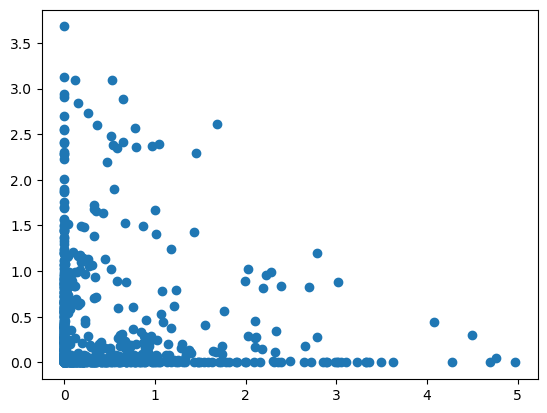

In [86]:
plt.scatter(nmf.components_[0, :], nmf.components_[1, :])

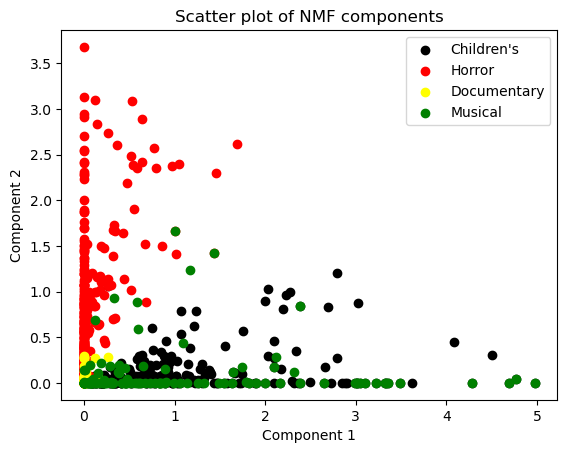

In [87]:
# Define colors for genres
genre_colors = {f'{genre1}': 'black', f'{genre2}': 'red', f'{genre3}': 'yellow', f'{genre4}': 'green'}

# Scatter plot
for genre, color in genre_colors.items():
    genre_movies = movies_col.find({'genres': {'$regex': genre}})
    genre_movie_ids = [movie['_id'] for movie in genre_movies]
    genre_indices = [filtered_movies_ids.index(movie_id) for movie_id in genre_movie_ids if movie_id in filtered_movies_ids]
    plt.scatter(nmf.components_[0, genre_indices], nmf.components_[1, genre_indices], label=genre, c=color)

plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of NMF components')
plt.show()

## 2) Data processing for more advanced model training

### Data spliting using timestamp values

In [88]:
# Query MongoDB to retrieve data
data = []
for user in users_col.find():
    user_id = user['_id']  # Extracting user_id from the '_id' field
    for movie in user['movies']:
        data.append({
            'user_id': user_id,
            'movie_id': movie['movieid'],
            'rating': movie['rating'],
            'timestamp': movie['timestamp']
        })

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame based on timestamp
df = df.sort_values(by='timestamp', ascending=False)

# Determine the split point (e.g., 80% train, 20% test)
train_size = 0.8
split_index = int(train_size * len(df))

# Split the data into train and test sets
train_df = df[:split_index]
test_df = df[split_index:]

In [89]:
test_df

,user_id,movie_id,rating,timestamp
226331,4611,3466,2,964152800
226523,4611,1682,4,964152800
226342,4611,3499,4,964152800
226478,4611,1280,3,964152753
226430,4611,34,4,964152753
...,...,...,...,...
324,6040,2019,5,956703977
139,6040,1961,4,956703977
5,6040,593,5,956703954
285,6040,2384,4,956703954


In [90]:
# Create a pivot table for my train_df
train_table = train_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)

# Display the pivot table
train_table

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
6002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Matching my train and test tables

In [91]:
# Get unique movie IDs from train and test sets
train_movie_ids = train_df['movie_id'].unique()
test_movie_ids = test_df['movie_id'].unique()

# Concatenate movie IDs from train and test sets
all_movie_ids = np.unique(np.concatenate([train_movie_ids, test_movie_ids]))

In [92]:
# Create a pivot table for the test set
test_table = test_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)

# Reindex test_table to include all movie_ids from both train and test sets
test_table = test_table.reindex(columns=all_movie_ids, fill_value=0)

test_table = test_table[train_table.columns]

# Display the pivot table
test_table

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
4611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4613,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
4614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4615,0,0,0,0,0,4,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,2,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### First real model training

In [95]:
# Parameters inputs
n_components = 10
max_iter = 500

# Train model on the filled training set
nmf = NMF(n_components=n_components, max_iter=max_iter)
nmf.fit(train_table.values)

# Generate predictions for train and test sets
pred_matrix = nmf.transform(test_table.values) @ nmf.components_

# Exporting my prediction data
df_pred_matrix = pd.DataFrame(pred_matrix, index=test_table.index, columns=train_table.columns)

# Unpivot df_pred_matrix
df_pred = df_pred_matrix.reset_index().melt(id_vars='user_id', var_name='movie_id', value_name='score')

# Join unpivoted predictions with the original train_df
df_pred = df_pred.merge(test_df, on=['user_id', 'movie_id'])

df_pred

,user_id,movie_id,score,rating,timestamp
0,4626,1,2.789801,2,964117136
1,4631,1,1.783435,3,964040271
2,4633,1,1.952819,3,964036615
3,4635,1,4.538733,4,964034339
4,4637,1,4.348214,3,964026538
...,...,...,...,...,...
200001,4951,3819,0.840642,4,963435368
200002,4979,3819,0.880815,5,963544577
200003,5034,3819,0.038419,5,963676163
200004,6016,3819,1.539741,4,963617607


In [115]:
# Sorting my df_pred by ascending users and descending scores
df_pred.sort_values(by=['user_id', 'score'], ascending=[True, False], inplace=True)

df_pred

,user_id,movie_id,score,rating,timestamp
130736,4611,2324,5.088439,5,964152495
13376,4611,260,5.022685,5,964151569
158405,4611,2858,5.002331,5,964151673
95841,4611,1617,4.981156,5,964152520
6973,4611,110,4.976377,5,964152442
...,...,...,...,...,...
111771,6040,1975,0.044697,1,956715569
186414,6040,3449,0.038525,3,956715966
167905,6040,3017,0.038036,1,956716519
123830,6040,2147,0.037899,2,956716588


In [116]:
# Filtering to only keep the 10 best scores for each user
top_10_per_user = df_pred.sort_values(by=['user_id', 'score'], ascending=[True, False]) \
                         .groupby('user_id').head(10)

top_10_per_user

,user_id,movie_id,score,rating,timestamp
130736,4611,2324,5.088439,5,964152495
13376,4611,260,5.022685,5,964151569
158405,4611,2858,5.002331,5,964151673
95841,4611,1617,4.981156,5,964152520
6973,4611,110,4.976377,5,964152442
...,...,...,...,...,...
45054,6040,912,5.162600,5,956704191
28970,6040,527,5.027692,5,956704219
33980,6040,593,5.009140,5,956703954
46152,6040,919,4.886499,5,956704191


In [117]:
# Using my top 10 movies to check my model performance
average_rating = top_10_per_user['rating'].mean()
diff_rating = 5 - average_rating
print("Average rating:", average_rating)
print("Difference from 5:", diff_rating)

Average rating: 4.561119707413138
Difference from 5: 0.43888029258686156


## 3) Model training with MLFlow logs

In [110]:
# Start MLflow run
with mlflow.start_run():

    # Tag settings
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    type = 'model_training'
    
    # Parameters inputs
    n_components = 150
    max_iter = 1000
    
    # Log parameters
    mlflow.log_params({
        "n_components": n_components,
        "max_iter": max_iter
    })

    # Train model on the training set
    nmf = NMF(n_components=n_components, max_iter=max_iter)
    nmf.fit(train_table.values)  # Training on the values of the aligned train_table

    # Generate predictions for train and test sets
    pred_matrix = nmf.transform(test_table.values) @ nmf.components_
    
    # Exporting my prediction data
    df_pred_matrix = pd.DataFrame(pred_matrix, index=test_table.index, columns=train_table.columns)
    df_pred = df_pred_matrix.reset_index().melt(id_vars='user_id', var_name='movie_id', value_name='score')
    df_pred = df_pred.merge(test_df, on=['user_id', 'movie_id'])
    df_pred.sort_values(by=['user_id', 'score'], ascending=[True, False], inplace=True)
    top_10_per_user = df_pred.sort_values(by=['user_id', 'score'], ascending=[True, False]) \
                         .groupby('user_id').head(10)

    # Calculating metrics
    average_rating = top_10_per_user['rating'].mean()
    diff_rating = 5 - average_rating

    # Log metrics
    mlflow.log_metric("average_rating", average_rating)
    mlflow.log_metric("rating_diff", diff_rating)

    # Log model
    mlflow.sklearn.log_model(nmf, "nmf_model")

    # Add tags
    mlflow.set_tag("type", type)
    mlflow.set_tag("date", current_date)

2024/02/14 12:24:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
